# Sad Poems

In [24]:
import numpy as np
import pandas as pd 
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 1000)
import random
import sys
import io
from bs4 import BeautifulSoup
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
import requests as rq
from matplotlib import pyplot

In [25]:
# loading additional nature poems from poetryfoundation.com dataset
pd.options.display.max_colwidth = 1000
df2 = pd.read_csv('PoetryFoundationData.csv') # load dataset
df2 = df2.dropna()
df2.head() # getting top 5 head

,Unnamed: 0,Title,Poem,Poet,Tags
6,6,\r\r\n Invisible Fish\r\r\n,"\r\r\nInvisible fish swim this ghost ocean now described by waves of sand, by water-worn rock. Soon the fish will learn to walk. Then humans will come ashore and paint dreams on the dying stone. Then later, much later, the ocean floor will be punctuated by Chevy trucks, carrying the dreamers’ decendants, who are going to the store.\r\r\n",Joy Harjo,"Living,Time & Brevity,Relationships,Family & Ancestors,Nature,Landscapes & Pastorals,Seas, Rivers, & Streams,Social Commentaries,History & Politics"
7,7,\r\r\n Don’t Bother the Earth Spirit\r\r\n,"\r\r\nDon’t bother the earth spirit who lives here. She is working on a story. It is the oldest story in the world and it is delicate, changing. If she sees you watching she will invite you in for coffee, give you warm bread, and you will be obligated to stay and listen. But this is no ordinary story. You will have to endure earthquakes, lightning, the deaths of all those you love, the most blinding beauty. It’s a story so compelling you may never want to leave; this is how she traps you. See that stone finger over there? That is the only one who ever escaped.\r\r\n",Joy Harjo,"Religion,The Spiritual,Mythology & Folklore,Fairy-tales & Legends"
9,9,"\r\r\n [""Hour in which I consider hydrangea""]\r\r\n","\r\r\nHour in which I consider hydrangea, a salt or sand plant, varietal, the question of varietals, the diet of every mother I know, 5 pounds feels like 20, I have lost … I have lost, yes, a sense of my own possible beauty, grown external, I externalize beauty. Beauty occurs on the surface of plants; the sun darkens the skin of my child, he is so small, he is beautiful (I can see; it is obvious) and everything about him is beautiful. His hand swells from the bite [spread?] of some insect[’s] venom because he is small. He appears to feel nothing. He smashes his skull against the floor. He screams. I hold him in my lap on the kitchen floor in front of an open freezer, pressing a pack of frozen clay against his forehead. He likes the cold. I see; it is so obvious. Hydrangea. When I move, when I walk pushing my child’s stroller (it is both walking and pushing or hauling, sometimes, also, lifting; it is having another body, an adjunct body composed of errand and weight and tenderness a...",Simone White,"Living,Parenthood,The Body,The Mind,Nature,Trees & Flowers"
16,16,\r\r\n scars\r\r\n,\r\r\nmy father’s body is a map\r\r\na record of his journey\r\r\n \r\r\nhe carries a bullet\r\r\nlodged in his left thigh\r\r\nthere is a hollow where it entered\r\r\na protruding bump where it sleeps\r\r\nthe doctors say it will never awaken\r\r\n \r\r\nit is the one souvenir he insists on keeping\r\r\nmother has her own opinionsbố cùa con điên—your father is crazy\r\r\n \r\r\nas a child\r\r\ni wanted a scar just like my father’s\r\r\nbold and appalling a mushroom explosion\r\r\nthat said i too was at war\r\r\ninstead i settled for a grain of rice\r\r\na scar so small look closely there\r\r\nhere between the eyes\r\r\na bit to the right\r\r\nthere on the bridge of my nose\r\r\n \r\r\nfather says i was too young to remember\r\r\nit happened while i was sleeping\r\r\nleaking roof the pounding rain\r\r\ndrop after drop after drop\r\r\n \r\r\n,Truong Tran,"The Body,Family & Ancestors"
17,17,\r\r\n what remains two\r\r\n,\r\r\nit has long been forgotten this practice of the mother\r\r\nweaning a child she crushes the seeds of a green\r\r\nchili rubs it to her nipple what the child feels\r\r\nshe too will share in this act of love\r\r\nmy own mother says it was not meant\r\r\nto be cruel when cruelty she tells me\r\r\nis a child’s lips torn from breast as proof\r\r\nback home the women wear teeth marks\r\r\n \r\r\n,Truong Tran,"Infancy,Parenthood,The Body"


In [26]:
searchfor = ['Sorrow']

In [27]:
# getting additional poems that contain the tag Love 
poems2 = df2['Poem']
sadPoems = poems2.loc[df2['Tags'].str.contains('|'.join(searchfor))]

In [28]:
sadPoems.head()


28                                                                                                                                                                                                                                                                                                                \r\r\nNothing can reach you now, not lead or steel,\r\r\nor what life itself eventually reveals.\r\r\n \r\r\nNo more studies of kindness or courtesy,\r\r\nnor grace or charity, all is needless now.\r\r\n \r\r\nAll is needless now, sky, world, family\r\r\ngrieving for their bundles of purity,\r\r\n \r\r\nnow beyond disgrace, failure, winter streets,\r\r\nor whatever attacks, and then retreats.\r\r\n \r\r\nClassrooms emptied of children’s things,\r\r\npaper and paste, and love’s imaginings,\r\r\n \r\r\nbundles of peace, Christmas-blessed\r\r\nwith the unborn and the dead at rest,\r\r\n \r\r\nnothing can reach you now, not lead or steel\r\r\nor what life itself eventually reveals.\r\r\n \

In [29]:
#convert nature series to a string
sadPoems = sadPoems.to_string()

In [30]:
# MAPPING CHARACTERS: for sad poems, Make two dictionaries , one to convert chars to ints, the other to convert ints back to chars

chars = sorted(list(set(sadPoems)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [31]:
# process the dataset:
seqlen = 100
step = seqlen

data_X = []
data_y = []

poemLines = [] 

# creates poem lines 
for i in range(0, len(sadPoems) - seqlen - 1, step):
    poemLines.append(sadPoems[i: i + seqlen + 1])
    
# creating x and y data
data_X = np.zeros((len(poemLines), seqlen, len(chars)), dtype=np.bool)
data_Y = np.zeros((len(poemLines), seqlen, len(chars)), dtype=np.bool)

for i, poemLines in enumerate(poemLines):
    for t, (char_in, char_out) in enumerate(zip(poemLines[:-1], poemLines[1:])):
        data_X[i, t, char_indices[char_in]] = 1
        data_Y[i, t, char_indices[char_out]] = 1

In [32]:
# create the model
model = Sequential()
model.add(LSTM(80, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.01), metrics=['categorical_crossentropy', 'accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 80)           67520     
_________________________________________________________________
dense_2 (Dense)              (None, 100, 130)          10530     
Total params: 78,050
Trainable params: 78,050
Non-trainable params: 0
_________________________________________________________________


In [33]:
# train the model
history = model.fit(data_X, data_Y, validation_split = .33, batch_size=128, epochs=10)

Train on 5691 samples, validate on 2804 samples
Epoch 1/10
5691/5691 [==============================] - 20s 3ms/step - loss: 2.8348 - categorical_crossentropy: 2.8348 - accuracy: 0.3140 - val_loss: 2.3048 - val_categorical_crossentropy: 2.3048 - val_accuracy: 0.4231
Epoch 2/10
5691/5691 [==============================] - 17s 3ms/step - loss: 2.1558 - categorical_crossentropy: 2.1558 - accuracy: 0.4147 - val_loss: 1.9541 - val_categorical_crossentropy: 1.9541 - val_accuracy: 0.4732
Epoch 3/10
5691/5691 [==============================] - 17s 3ms/step - loss: 1.8797 - categorical_crossentropy: 1.8797 - accuracy: 0.4752 - val_loss: 1.7530 - val_categorical_crossentropy: 1.7530 - val_accuracy: 0.5120
Epoch 4/10
5691/5691 [==============================] - 17s 3ms/step - loss: 1.7437 - categorical_crossentropy: 1.7437 - accuracy: 0.5055 - val_loss: 1.6446 - val_categorical_crossentropy: 1.6446 - val_accuracy: 0.5387
Epoch 5/10
5691/5691 [==============================] - 17s 3ms/step - loss:

In [34]:
# evaluate the model on validation set and vizualise
#history = model.fit(data_X, data_Y, validation_split = .33, batch_size=128, epochs=10)

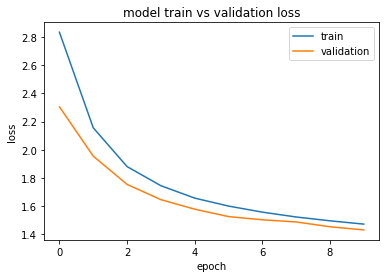

In [35]:
#to plot the train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

**Generating Poems**

In [36]:
def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)  

In [48]:
def generating_poem(poem_length, start_index, diversity, _):
    
    start_index = start_index
    diversity = diversity

    generated = ''
    poemLines = sadPoems[start_index: start_index + seqlen]
    generated += poemLines
    print('----- Generating with seed: "' + poemLines + '"')
    sys.stdout.write(generated)

    for i in range(poem_length):
        x_pred = np.zeros((1, seqlen, len(chars)))
        for t, char in enumerate(poemLines):
            x_pred[0, t, char_indices[char]] = 1.
            
        preds = model.predict(x_pred, verbose=0)
        next_index = sample(preds[0, -1], diversity)
        next_char = indices_char[next_index]

        poemLines = poemLines[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

In [49]:
randStart = 750
generating_poem(500, randStart, .5, _)

----- Generating with seed: "things,\r\r\npaper and paste, and love’s imaginings,\r\r\n \r\r\nbundles of peace, Christmas-blessed"
things,\r\r\npaper and paste, and love’s imaginings,\r\r\n \r\r\nbundles of peace, Christmas-blessed that of the the bed the come of the recictle of the wanking the plastle the mender to be for the some the some sight a for a startered the were the creach of the chores on the could in in the warlen’s the face of the sone poon of the seart of you caring the wird. The widder the pour the were a door to mister of the bricked to a shaw with to me, lever sirst and the died from her words, the she wind the secking to be                                                                                 
